In [29]:
# Install thai2transformer 
!pip -q install torch==1.5.0 torchtext==0.4.0 torchvision==0.6.0
!pip -q install transformers==3.5.0 thai2transformers==0.1.2

In [30]:
import numpy as np
from tqdm.auto import tqdm
import torch

#datasets
from datasets import load_dataset

#transformers
from transformers import (
    CamembertTokenizer,
    AutoTokenizer,
    AutoModel,
    AutoModelForMaskedLM,
    AutoModelForSequenceClassification,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    pipeline,
)

#thai2transformers
import thai2transformers
from thai2transformers.preprocess import process_transformers
from thai2transformers.metrics import (
    classification_metrics, 
    multilabel_classification_metrics,
)
from thai2transformers.tokenizers import (
    ThaiRobertaTokenizer,
    ThaiWordsNewmmTokenizer,
    ThaiWordsSyllableTokenizer,
    FakeSefrCutTokenizer,
    SEFR_SPLIT_TOKEN
)

In [31]:
model_names = [
    'wangchanberta-base-att-spm-uncased',
    'xlm-roberta-base',
    'bert-base-multilingual-cased',
    'wangchanberta-base-wiki-newmm',
    'wangchanberta-base-wiki-ssg',
    'wangchanberta-base-wiki-sefr',
    'wangchanberta-base-wiki-spm',
]

tokenizers = {
    'wangchanberta-base-att-spm-uncased': AutoTokenizer,
    'xlm-roberta-base': AutoTokenizer,
    'bert-base-multilingual-cased': AutoTokenizer,
    'wangchanberta-base-wiki-newmm': ThaiWordsNewmmTokenizer,
    'wangchanberta-base-wiki-ssg': ThaiWordsSyllableTokenizer,
    'wangchanberta-base-wiki-sefr': FakeSefrCutTokenizer,
    'wangchanberta-base-wiki-spm': ThaiRobertaTokenizer,
}
public_models = ['xlm-roberta-base', 'bert-base-multilingual-cased'] 
#@title Choose Pretrained Model
model_name = "wangchanberta-base-att-spm-uncased" #@param ["wangchanberta-base-att-spm-uncased", "xlm-roberta-base", "bert-base-multilingual-cased", "wangchanberta-base-wiki-newmm", "wangchanberta-base-wiki-syllable", "wangchanberta-base-wiki-sefr", "wangchanberta-base-wiki-spm"]

#create tokenizer
tokenizer = tokenizers[model_name].from_pretrained(
                f'airesearch/{model_name}' if model_name not in public_models else f'{model_name}',
                revision='main',
                model_max_length=416,)


# Sentiment Analysis

In [32]:
#@title Choose Multi-class Classification Dataset
dataset_name = "wisesight_sentiment" #@param ['wisesight_sentiment','wongnai_reviews']

#pipeline
classify_multiclass = pipeline(task='sentiment-analysis',
         tokenizer=tokenizer,
         model = f'airesearch/{model_name}' if model_name not in public_models else f'{model_name}',
         revision = f'finetuned@{dataset_name}')

# COMPANY

### Input Data

In [80]:
# main library
import pandas as pd
import numpy as np
data = pd.read_excel('/content/Shopee_Tweet_NEW.xlsx')
data.shape

(4458, 4)

In [81]:
data.head()

,Create_at,clean_text,Sentiment,Topics
0,2021-01-05,ใช่ค่ะ ตอนแรกบอกว่าให้กดรับของได้เลยแล้วจะส่งใ...,neg,Company
1,2021-01-05,อยากให้เรื่องนี้แมส เผื่อว่า จะออกมารับผิดชอบอ...,neg,Company
2,2021-02-06,ขอบคุณบริษัทช้อปปี้มากฮะที่แอดมินพาพี่มายกับอา...,pos,Company
3,2021-03-26,บอกลาบริษัทช้อปปี้ก่อนนะ แอดมินแบบนี้ ซื้อด้วย...,neg,Company
4,2021-02-01,เรากดสั่งของไปรอของมาจนวันนี้ ไม่ส่งซักที วันน...,neg,Company


In [82]:
sentiment_rate = data.groupby('Sentiment').agg({'clean_text': lambda x: len(x)}).reset_index()
sentiment_rate.head()

,Sentiment,clean_text
0,neg,1838
1,neu,1447
2,pos,1173


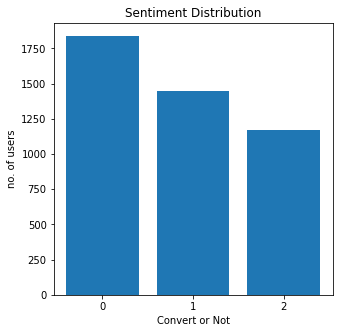

In [83]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
x=range(3)
plt.bar(x,sentiment_rate['clean_text'])
plt.xticks(sentiment_rate.index)
plt.title('Sentiment Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

#Data is imbalanced

### Fixing imbalanced data

In [84]:
# fixing Imbalanced data
neg = data.loc[lambda data: data['Sentiment'] == 'neg']
neu = data.loc[lambda data: data['Sentiment'] == 'neu']
pos = data.loc[lambda data: data['Sentiment'] == 'pos']
sampling_neg = neg.sample(frac =0.64, random_state=42)
sampling_neu = neu.sample(frac =0.81, random_state=42)
sampling_pos = pos.sample(frac =0.86, random_state=42)
print(sampling_neg)
print(sampling_neu)
print(pos)
#print(pos)

      Create_at  ...     Topics
3774 2021-03-14  ...      Store
2624 2021-03-14  ...      Store
705  2021-01-11  ...  Logistics
786  2021-01-11  ...  Logistics
3253 2021-04-04  ...      Store
...         ...  ...        ...
701  2021-01-11  ...  Logistics
747  2021-01-11  ...  Logistics
1953 2021-02-04  ...  Promotion
1637 2021-01-13  ...  Logistics
1511 2021-04-04  ...  Logistics

[1176 rows x 4 columns]
      Create_at  ...     Topics
3315 2021-05-04  ...      Store
1636 2021-01-12  ...  Logistics
2921 2021-03-15  ...      Store
1762 2021-02-09  ...  Promotion
798  2021-03-02  ...  Logistics
...         ...  ...        ...
1037 2021-01-11  ...  Logistics
99   2021-02-20  ...    Company
1778 2021-01-07  ...  Promotion
4356 2021-03-17  ...     System
1050 2021-01-11  ...  Logistics

[1172 rows x 4 columns]
      Create_at  ...   Topics
2    2021-02-06  ...  Company
7    2021-04-05  ...  Company
14   2021-03-26  ...  Company
20   2021-03-26  ...  Company
21   2021-03-26  ...  Company
..

In [85]:
# append columns 
df1 = sampling_neg.append(sampling_neu, ignore_index=True)
df = df1.append(pos, ignore_index=True)
df

,Create_at,clean_text,Sentiment,Topics
0,2021-03-14,บัตรเครดิตกุโดนแฮคจ้าาา ไม่แน่ใจว่าแฮคได้ไง แต...,neg,Store
1,2021-03-14,อะเอาผิดเรื่องสินค้าไม่ตรงปกด้วยค่ะ แล้วก็เรื่...,neg,Store
2,2021-01-11,ช้อปปี้ ดองของส่งช้ามากกกก มึงไม่ให้กูเลือกอะอ...,neg,Logistics
3,2021-01-11,ช้อปปี้​ Express​ ส่งของช้ามากคร๊​ ถ้าเลือกขนส...,neg,Logistics
4,2021-04-04,กุเบื่อการกดสั่งของในช้อปปี้อย่างคือตอนกดอ่ะมี...,neg,Store
...,...,...,...,...
3516,2021-03-16,แอพช้อปปี้ มีทุกอย่างเชื่อพี่,pos,System
3517,2021-03-17,ตอนแอพช้อปปี้3 3กูกดอะไรไปบ้างเนี่ย เสียเงินซื...,pos,System
3518,2021-03-18,แต่เฟยชอบเวลาแอพช้อปปี้แจ้งเตือนมาก เสียงน่ารัก,pos,System
3519,2021-03-28,ใช่ๆ ระบบช้อปปี้ดีกว่าเยอะมากเลย,pos,System


In [86]:
sentiment_rate_sampling = df.groupby('Sentiment').agg({'clean_text': lambda x: len(x)}).reset_index()
sentiment_rate_sampling.head()

,Sentiment,clean_text
0,neg,1176
1,neu,1172
2,pos,1173


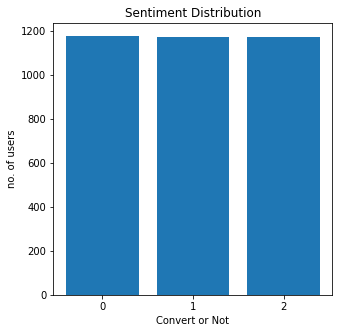

In [87]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
x=range(3)
plt.bar(x,sentiment_rate_sampling['clean_text'])
plt.xticks(sentiment_rate_sampling.index)
plt.title('Sentiment Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

#Data is imbalanced

### wangchanBERTa 

In [88]:
#input data in model
input_text = [text for text in data['clean_text']]

preprocess_input_text = False #@param {type:"boolean"}
if preprocess_input_text:
    if model_name not in public_models:
        input_text = process_transformers(input_text)

#infer
classify_text = classify_multiclass(input_text)

In [89]:
print(classify_text)

[{'label': 'neg', 'score': 0.9799124002456665}, {'label': 'neg', 'score': 0.5821601152420044}, {'label': 'pos', 'score': 0.9492441415786743}, {'label': 'neg', 'score': 0.990360677242279}, {'label': 'neg', 'score': 0.913079023361206}, {'label': 'neg', 'score': 0.7473710179328918}, {'label': 'neg', 'score': 0.9876369833946228}, {'label': 'pos', 'score': 0.9172630310058594}, {'label': 'neg', 'score': 0.859544038772583}, {'label': 'neg', 'score': 0.9929788112640381}, {'label': 'neg', 'score': 0.9791341423988342}, {'label': 'neu', 'score': 0.8450835943222046}, {'label': 'neg', 'score': 0.983352541923523}, {'label': 'neg', 'score': 0.9775782227516174}, {'label': 'pos', 'score': 0.5862798094749451}, {'label': 'neg', 'score': 0.9855992197990417}, {'label': 'neg', 'score': 0.9950881004333496}, {'label': 'neg', 'score': 0.9919668436050415}, {'label': 'neg', 'score': 0.9242462515830994}, {'label': 'neu', 'score': 0.886389970779419}, {'label': 'pos', 'score': 0.8596080541610718}, {'label': 'pos', 

In [90]:
len(classify_text)

4458

In [91]:
df_score = pd.DataFrame(classify_text, columns=['label', 'score'])
df_score.head(60)

,label,score
0,neg,0.979912
1,neg,0.582160
2,pos,0.949244
3,neg,0.990361
4,neg,0.913079
5,neg,0.747371
6,neg,0.987637
7,pos,0.917263
8,neg,0.859544
9,neg,0.992979


In [92]:
data.insert(loc=1,column='label',value=df_score.label)

In [93]:
data.insert(loc=2,column='score',value=df_score.score)

In [94]:
data

,Create_at,label,score,clean_text,Sentiment,Topics
0,2021-01-05,neg,0.979912,ใช่ค่ะ ตอนแรกบอกว่าให้กดรับของได้เลยแล้วจะส่งใ...,neg,Company
1,2021-01-05,neg,0.582160,อยากให้เรื่องนี้แมส เผื่อว่า จะออกมารับผิดชอบอ...,neg,Company
2,2021-02-06,pos,0.949244,ขอบคุณบริษัทช้อปปี้มากฮะที่แอดมินพาพี่มายกับอา...,pos,Company
3,2021-03-26,neg,0.990361,บอกลาบริษัทช้อปปี้ก่อนนะ แอดมินแบบนี้ ซื้อด้วย...,neg,Company
4,2021-02-01,neg,0.913079,เรากดสั่งของไปรอของมาจนวันนี้ ไม่ส่งซักที วันน...,neg,Company
...,...,...,...,...,...,...
4453,2021-03-26,neg,0.993256,แอพช้อปปี้ขนส่งห่วยจริงกูการันตี เปลี่ยนยังไงใ...,neg,System
4454,2021-03-27,neu,0.544173,เป็นแค่แอพขายของ ทำไมต้องเข้าถึงข้อมูลรูปภาพด้วย,neu,System
4455,2021-03-28,neg,0.444280,ใช่ๆ ระบบช้อปปี้ดีกว่าเยอะมากเลย,pos,System
4456,2021-03-29,pos,0.752813,ไปค่ะพุ่งออกจากแอพช้อปปี้เข้ายูทูปต่อค่ะ,pos,System


In [95]:
data['label'].unique()

array(['neg', 'pos', 'neu', 'q'], dtype=object)

In [96]:
data['Sentiment'].unique()

array(['neg', 'pos', 'neu'], dtype=object)

In [97]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4458 entries, 0 to 4457
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Create_at   4458 non-null   datetime64[ns]
 1   label       4458 non-null   object        
 2   score       4458 non-null   float64       
 3   clean_text  4458 non-null   object        
 4   Sentiment   4458 non-null   object        
 5   Topics      4458 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 209.1+ KB
None


### Evaluation model

In [98]:
data['Sentiment'] = data.Sentiment.map({'neg':0, 'pos':1, 'neu':2})
data['label'] = data.label.map({'neg':0, 'pos':1, 'neu':2, 'q' : 2})

In [99]:
#data['label'] = data['label'].astype(str).replace('\.0', '', regex=True)

In [104]:
data

,Create_at,label,score,clean_text,Sentiment,Topics
0,2021-01-05,0,0.979912,ใช่ค่ะ ตอนแรกบอกว่าให้กดรับของได้เลยแล้วจะส่งใ...,0,Company
1,2021-01-05,0,0.582160,อยากให้เรื่องนี้แมส เผื่อว่า จะออกมารับผิดชอบอ...,0,Company
2,2021-02-06,1,0.949244,ขอบคุณบริษัทช้อปปี้มากฮะที่แอดมินพาพี่มายกับอา...,1,Company
3,2021-03-26,0,0.990361,บอกลาบริษัทช้อปปี้ก่อนนะ แอดมินแบบนี้ ซื้อด้วย...,0,Company
4,2021-02-01,0,0.913079,เรากดสั่งของไปรอของมาจนวันนี้ ไม่ส่งซักที วันน...,0,Company
...,...,...,...,...,...,...
4453,2021-03-26,0,0.993256,แอพช้อปปี้ขนส่งห่วยจริงกูการันตี เปลี่ยนยังไงใ...,0,System
4454,2021-03-27,2,0.544173,เป็นแค่แอพขายของ ทำไมต้องเข้าถึงข้อมูลรูปภาพด้วย,2,System
4455,2021-03-28,0,0.444280,ใช่ๆ ระบบช้อปปี้ดีกว่าเยอะมากเลย,1,System
4456,2021-03-29,1,0.752813,ไปค่ะพุ่งออกจากแอพช้อปปี้เข้ายูทูปต่อค่ะ,1,System


In [101]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4458 entries, 0 to 4457
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Create_at   4458 non-null   datetime64[ns]
 1   label       4458 non-null   int64         
 2   score       4458 non-null   float64       
 3   clean_text  4458 non-null   object        
 4   Sentiment   4458 non-null   int64         
 5   Topics      4458 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 209.1+ KB
None


In [102]:
from sklearn.metrics import classification_report, confusion_matrix
  
y_pred = data['label']
y_true = data['Sentiment']

print('System')
print('test')
target_names = ['Negative', 'Positive', 'Neutral']
print(classification_report(y_true,y_pred,target_names=target_names))

System
test
              precision    recall  f1-score   support

    Negative       0.77      0.98      0.87      1838
    Positive       0.95      0.57      0.72      1173
     Neutral       0.76      0.75      0.76      1447

    accuracy                           0.80      4458
   macro avg       0.83      0.77      0.78      4458
weighted avg       0.82      0.80      0.79      4458



In [106]:
data.to_excel('data_wangchanBERTa.xlsx')

# Topic Modeling

In [ ]:
#pipeline
zero_classify = pipeline(task='zero-shot-classification',
         tokenizer=tokenizer,
         model=AutoModelForSequenceClassification.from_pretrained(
             f'airesearch/{model_name}' if model_name not in public_models else f'airesearch/{model_name}-finetuned',
             revision='finetuned@xnli_th')
         )

In [ ]:
input_text2 = 'อิควาย คือแต่ก่อนส่งฟรีแบบไม่แอร์เพย์ ละเปลี่ยนมาส่งฟรีแอร์เพย์ ละก็เปลี่ยนมาส่งฟรีแอร์เพย์ได้เดือนละ4ครั้ง ละก็เปลี่ยนมาส่งฟรีเดือนละ2ครั้ง ละก็เปลี่ยนอีกเป็นเดือนละ2ครั้งและร้านนั้นต้องเป็นfree shipping specialอะไรไม่รู้อีก เหี้ยอะไรของมึง'
#input_text2 = [text2 for text2 in data['clean_text']]
preprocess_input_text = True #@param {type:"boolean"}
if preprocess_input_text:
    if model_name not in public_models:
        input_text = process_transformers(str(input_text2))

#infer
zero_classify(input_text, 
              candidate_labels=['ระบบ','ขนส่ง','บริษัท','โปรโมชั่น','ร้านค้า'],
              hypothesis_template='ลูกค้าพูดเกี่ยวกับ{}')

{'labels': ['ขนส่ง', 'ร้านค้า', 'โปรโมชั่น', 'ระบบ', 'บริษัท'],
 'scores': [0.28293004631996155,
  0.25567400455474854,
  0.24590718746185303,
  0.13690268993377686,
  0.07858608663082123],
 'sequence': 'อิควาย<_>คือแต่ก่อนส่งฟรีแบบไม่แอร์เพย์<_>ละเปลี่ยนมาส่งฟรีแอร์เพย์<_>ละก็เปลี่ยนมาส่งฟรีแอร์เพย์ได้เดือนละ4ครั้ง<_>ละก็เปลี่ยนมาส่งฟรีเดือนละ2ครั้ง<_>ละก็เปลี่ยนอีกเป็นเดือนละ2ครั้งและร้านนั้นต้องเป็นfree<_>shipping<_>specialอะไรไม่รู้อีก<_>เหี้ยอะไรของมึง'}